In [1]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])

    dt= v[:, -1].mean()*0.001
    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t, dt

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x, wheel_diameter = 34.0*0.001, wheel_brace = 80.0*0.001):

    n_steps = x.shape[0]

    left_position = x[:, 0]
    right_position= x[:, 1] 

    #transform wheels traveled distance into robot frame
    distance = 0.25*(right_position + left_position)*wheel_diameter
    angle    = 0.5*(right_position - left_position)*wheel_diameter / wheel_brace

    #zero initial conditions
    distance = distance - distance[0]
    angle    = angle - angle[0]

    x_aug = numpy.zeros((n_steps, 2))
    x_aug[:, 0] = distance
    x_aug[:, 1] = angle

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()
    
    fig, axs = plt.subplots(6, 1, figsize=(8, 2*8))


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [m]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1], color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1], color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [rad]")
    axs[3].grid()

    
    axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], color="red")
    axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], color="blue")
    axs[4].set_xlabel("time [s]")
    axs[4].set_ylabel("velocity")
    axs[4].grid()

    axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3], color="red")
    axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3], color="blue")
    axs[5].set_xlabel("time [s]")
    axs[5].set_ylabel("angular velocity")
    axs[5].grid()

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [2]:
#obtain response
u_result, x_ref, t_result, dt = load_from_file("./data/run_4.log")
x_ref = state_augmentation(x_ref)


#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.zeros((a_est.shape[0]//2, a_est.shape[0]))
for n in range(a_est.shape[0]//2):
    c_est[n][n] = 1.0


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")


n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]



mat_a = 
 [[ 1.00019423e+00  1.69899659e-06  7.87560370e-03  9.92817173e-04]
 [-5.33751491e-04  1.00044579e+00  2.24874012e+00 -1.28693456e-01]
 [ 1.93990856e-04  1.70073556e-06  8.59139100e-03  9.84420597e-04]
 [-5.33748876e-04  4.45784922e-04  2.24873172e+00 -1.28692146e-01]] 


mat_b = 
 [[ 3.55108432e-05  3.39298662e-05]
 [-1.05574913e-03  8.88919110e-04]
 [ 3.54787884e-05  3.39119367e-05]
 [-1.05574770e-03  8.88918282e-04]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]] 




<Figure size 640x480 with 0 Axes>

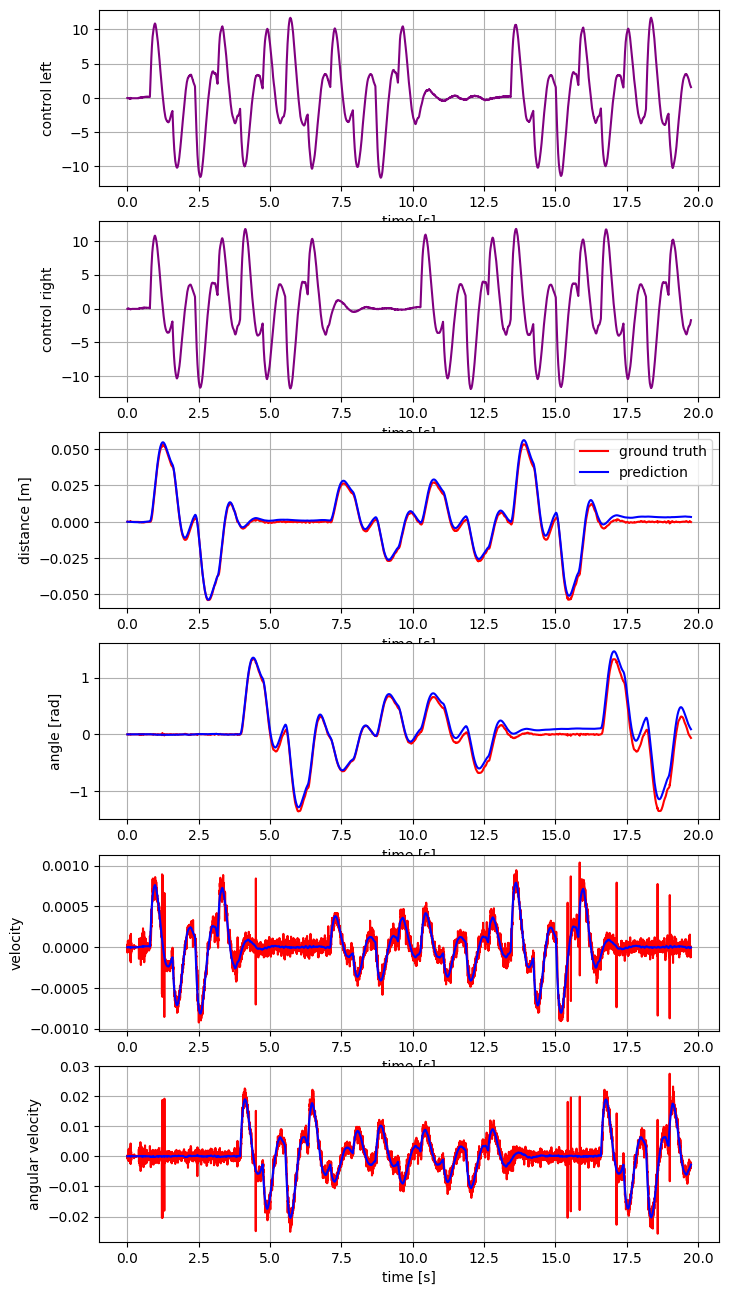

In [3]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, None)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = [] 

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)

#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [4]:
#controller synthetis

#process and observation noise covariance
q_noise = 0.1*numpy.eye(a_est.shape[0]) 
r_noise = 0.1*numpy.eye(c_est.shape[0]) 
 

#create loss weighting matrices (diagonal)
q = numpy.diag([ 500.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [1.0, 1.0]) 

#1400rpm max
antiwindup = (1400/60.0)*2.0*numpy.pi

#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, q_noise, r_noise, antiwindup)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")



controller
k  = 
 [[686.68333546 -29.58065685 -51.58099284   3.8455534 ]
 [696.0187941   29.47586806  64.76080148  -2.63198004]] 

ki = 
 [[16.11042542 -0.72844552]
 [16.26777337  0.72138279]] 

f  = 
 [[6.18079456e-01 9.01667952e-04]
 [9.01667952e-04 8.72114168e-01]
 [5.59750071e-05 2.50884565e-03]
 [1.92440408e-03 6.42499473e-01]] 






<Figure size 640x480 with 0 Axes>

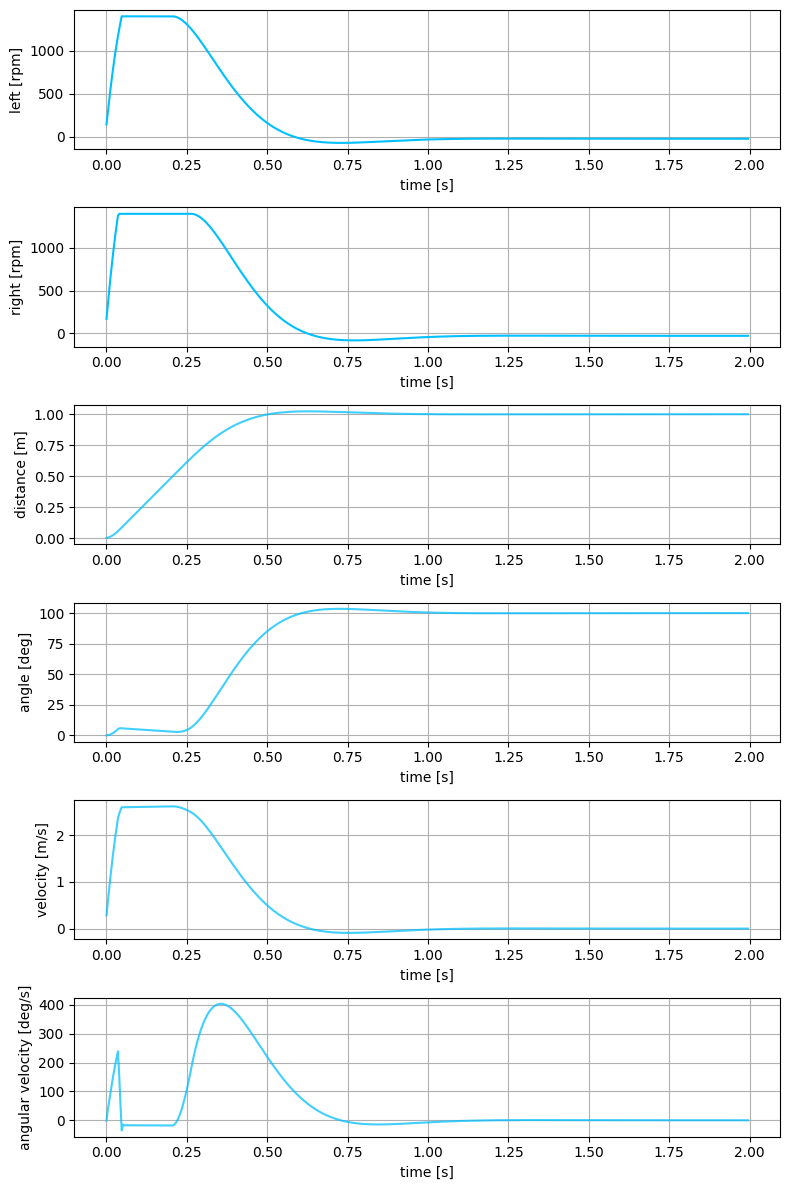

In [5]:
#process simulation

n_max = int(2.0/dt)

#required output, 1 meter, 100degrees
yr = numpy.array([[1.0, 100.0*numpy.pi/180.0]]).T
y = numpy.zeros_like(yr)

#plant state
x     = numpy.zeros((a_est.shape[0], 1))
x_hat = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []

for n in range(n_max):

    #compute controller output
    u, integral_action, x_hat = lqg.forward(yr, y, integral_action, x_hat)
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)


u_result*= 60.0*1.0/(2.0*numpy.pi)


#velocity to m/s
x_result[:, 2]*= 1.0/dt

#convert angle and agular velocity to degrees
x_result[:, 1]*= 180.0/numpy.pi 
x_result[:, 3]*= (180.0/numpy.pi)/dt

#plot results
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["left [rpm]", "right [rpm]"], x_labels = ["distance [m]", "angle [deg]", "velocity [m/s]", "angular velocity [deg/s]"])


In [6]:
#print c-like arrays

print(matrix_to_c("mat_a", a_est))
print(matrix_to_c("mat_b", b_est))
print(matrix_to_c("mat_c", c_est))
print(matrix_to_c("k", lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f", lqg.f))

float mat_a[] = {
		1.0001942, 1.6989966e-06, 0.007875604, 0.0009928172, 
		-0.0005337515, 1.0004458, 2.2487402, -0.12869346, 
		0.00019399085, 1.7007355e-06, 0.008591391, 0.0009844207, 
		-0.0005337489, 0.0004457849, 2.2487316, -0.12869215 };

float mat_b[] = {
		3.5510842e-05, 3.3929868e-05, 
		-0.0010557491, 0.0008889191, 
		3.5478788e-05, 3.3911936e-05, 
		-0.0010557477, 0.0008889183 };

float mat_c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0 };

float k[] = {
		686.68335, -29.580656, -51.580994, 3.8455534, 
		696.0188, 29.475868, 64.7608, -2.63198 };

float ki[] = {
		16.110426, -0.72844553, 
		16.267773, 0.7213828 };

float f[] = {
		0.6180795, 0.0009016679, 
		0.0009016679, 0.8721142, 
		5.5975008e-05, 0.0025088456, 
		0.0019244041, 0.64249945 };

